##**Fruit Plant Leaf Detection and Disease Recognition using PyTorch**

Project By:
             Muhammad Adeel 2022331
              Saud Khan 2022533

This project aims to create a robust fruit plant disease recognition model using deep convolutional neural networks for leaf image classification.

###Importing the Fruit Plant Disease Dataset from Kaggle

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'new-plant-diseases-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F78313%2F182633%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240421%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240421T121611Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9aa9a3f06bd51df7a7a304dee53bb0bd193b7916c7fa81ae88d432149427be12b878a6fc63df4959485bfb4672182f3dbc5b34778e8dbf681cb42df13da2d4454cf22db55db924cbe354016d00fa55a0c54a9f93b1e5436e051f88e022ddfc9578b7a0f0b46483a958154273afc9712f9e9608b34d1eb6b53a041f9ee5256d3a63bc7afe10066fe0015449cea9913fc689d47a7812add9110c6dce539d856fc1190b44922ce58f723b4a9835be053a0f7a96a9947eafece9b0f9b029e64cf44a2449f9902ce20c11db4c9a27618d183c3763e345e38b6ffa3c78a5fc834efb64f4969b9c9d70cfdb4065c17c76b71de7f2ed6c5afc256b6eeed799f1ca0b3ef9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2897709187 bytes downloaded
Downloaded and uncompressed: new-plant-diseases-dataset
Data source import complete.


## Importing Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
#Importing Libraries for Deep learning and Computer Vision tasks
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,TensorDataset
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from tqdm.notebook import tqdm

In [ ]:
project_name = 'plant-disease-classification'

data ='../input/new-plant-diseases-dataset/'
os.listdir(data)

['New Plant Diseases Dataset(Augmented)',
 'new plant diseases dataset(augmented)',
 'test']

#**Data Preprocessing**

In [ ]:
#list the contents of a Dataset folder
os.listdir(data+'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)')

#listing the contents within Dataset train folder
os.listdir(data+'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train')

['Corn_(maize)___healthy',
 'Grape___Esca_(Black_Measles)',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Tomato___healthy',
 'Tomato___Bacterial_spot',
 'Pepper,_bell___Bacterial_spot',
 'Apple___Black_rot',
 'Potato___Early_blight',
 'Tomato___Late_blight',
 'Cherry_(including_sour)___healthy',
 'Tomato___Septoria_leaf_spot',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Cherry_(including_sour)___Powdery_mildew',
 'Potato___healthy',
 'Strawberry___Leaf_scorch',
 'Grape___healthy',
 'Peach___healthy',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Apple___Apple_scab',
 'Raspberry___healthy',
 'Tomato___Early_blight',
 'Tomato___Target_Spot',
 'Apple___Cedar_apple_rust',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Soybean___healthy',
 'Strawberry___healthy',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Peach___Bacterial_spot',
 'Grape___Black_rot',
 'Apple___healthy',
 'Tomato___Tomato_mosaic_virus',
 'Blueberry___healthy',
 'Tomato___Leaf_Mold',
 'Corn_(maize)___Common_rust_',

In [ ]:
#to find the no. of unique plants and list them into a list
unique_plants = []
cl = os.listdir(data+'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train')
for i in cl:
    x = i.split('_')
    if x[0] not in unique_plants:
        unique_plants.append(x[0])
print("Number of Unique Plants: ",len(unique_plants))
print("Unique Plants: ",unique_plants)

Number of Unique Plants:  14
Unique Plants:  ['Corn', 'Grape', 'Orange', 'Tomato', 'Pepper,', 'Apple', 'Potato', 'Cherry', 'Strawberry', 'Peach', 'Raspberry', 'Soybean', 'Blueberry', 'Squash']


## Loading Training and Test Dataset as Tensor
'transforms.Compose' combines these transformations into a single transformation pipeline, which can then be applied to input images or datasets. This particular pipeline first resizes the images to 128x128 pixels and then converts them to PyTorch tensors.

In [ ]:
transform = transforms.Compose(
    [transforms.Resize(size = 128),
     transforms.ToTensor()])

In [ ]:
dataset = ImageFolder(data+'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train',transform=transform)
test_ds = ImageFolder(data+'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid',transform=transform)

print("Number of training images: ",len(dataset))
print("Number of testing images: ",len(test_ds))

Number of training images:  70295
Number of testing images:  17572


In [ ]:
#Number of classes
num_classes = dataset.classes
print("Number of classes: ",len(num_classes))
print(num_classes)

Number of classes:  38
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mit

## Validation Dataset and Dataloader

In [ ]:
# setting a random seed allows you to
#control the randomness and ensure reproducibility of results.
random_seed = 42
torch.manual_seed(random_seed)

validation_split = 0.3
val_size = int(len(dataset) * validation_split)
train_size = len(dataset) - val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])

batch_size = 64

train_loader = DataLoader(train_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)
test_loader = DataLoader(test_ds,batch_size=batch_size,num_workers=2,shuffle=True, pin_memory=True)

## Visualising a Batch of images

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


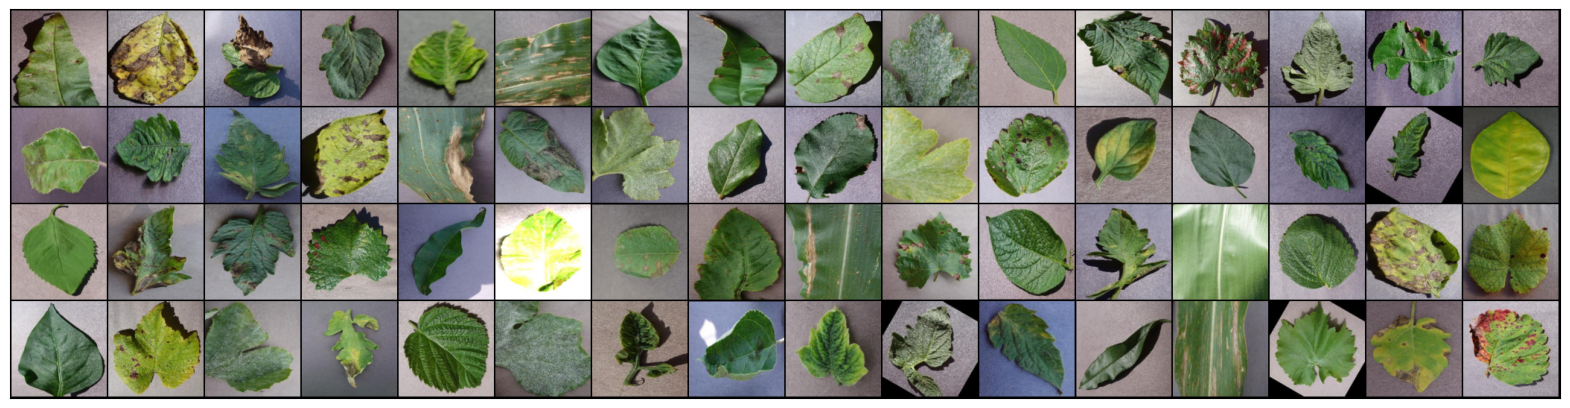

In [ ]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

## Building The Model

### Building a Base Image Classification Model

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):

  def training_step(self,batch): #computes the output for input images & calculates the loss
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch): #calculates cross-entropy loss and accuracy
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss':loss,'val_acc':acc}

  def validation_epoch_end(self,outputs): # returns the average validation loss and accuracy for every epoch.
    batch_loss = [out['val_loss'] for out in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [out['val_acc'] for out in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epoch_end(self,epoch,result): # prints the training, validation losses, and accuracy
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

### Buiding a  CNN model

In [ ]:
class Plant_Disease_Model(ImageClassificationBase):

  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1), # network architecture consists of several convolutional layers followed by ReLU activation functions and max-pooling layers.
        nn.ReLU(),                                    #followed by ReLU activation functions and max-pooling layers.
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 64*64*64

        nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 128*32*32

        nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 256*16*16

        nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 512*8*8

        nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(512,1024,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 1024*4*4
        nn.AdaptiveAvgPool2d(1),

        nn.Flatten(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,38)
        )

  def forward(self,xb): #defines the forward pass of the model.
    out = self.network(xb)
    return out

###VGG16 model

In [ ]:
class Plant_Disease_Model1(ImageClassificationBase):

  def __init__(self):
    super().__init__()
    self.network = models.vgg16(pretrained=True)
    num_ftrs = self.network.classifier[-1].in_features
    self.network.classifier[-1] = nn.Linear(num_ftrs, 38)

  def forward(self,xb):
    out = self.network(xb)
    return out

###Resnet34 model

In [ ]:
class Plant_Disease_Model2(ImageClassificationBase):

  def __init__(self):
    super().__init__()
    self.network = models.resnet34(pretrained=True)
    num_ftrs = self.network.fc.in_features
    self.network.fc = nn.Linear(num_ftrs, 38)

  def forward(self,xb):
    out = self.network(xb)
    return out

## Training and Evaluation

In [ ]:
@torch.no_grad()   # disable gradient calculation during the evaluation.

def evaluate(model,val_loader): #used to evaluate model on val dataset
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)
  #returns the average loss and accuracy across all batches

In [ ]:
# fxn to train the model for specified no. of epochs
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in tqdm(train_loader):
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history #history listc contains training and validation metrics for each epoch

## Using GPU
fxns to switch between CPU and GPU for training to enhance effeciency

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
#move batches of data to the specified device (GPU or CPU) during iteration.
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
#used to move the model to the specified device (GPU or CPU)
model = to_device(Plant_Disease_Model2(), device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [1]:
#display the architecture and parameters of the model,
#model

## Training the model

In [ ]:
evaluate(model,val_loader)

{'val_loss': 3.9106154441833496, 'val_acc': 0.024715909734368324}

In [ ]:
# training process for 10 epochs,learning rate: 0.001, using the Adam optimizer
history = fit(10, 0.001, model, train_loader, val_loader, opt_func = torch.optim.Adam)

  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.3628, val_loss: 0.5884, val_acc: 0.8435


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.1237, val_loss: 0.2713, val_acc: 0.9226


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0908, val_loss: 0.2080, val_acc: 0.9381


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0763, val_loss: 0.1081, val_acc: 0.9641


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0548, val_loss: 0.1654, val_acc: 0.9525


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.0613, val_loss: 0.1795, val_acc: 0.9458


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.0432, val_loss: 0.2891, val_acc: 0.9280


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.0419, val_loss: 0.0736, val_acc: 0.9757


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.0385, val_loss: 0.0951, val_acc: 0.9734


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.0332, val_loss: 0.0545, val_acc: 0.9827


In [ ]:
history += fit(5, 0.001, model, train_loader, val_loader, opt_func = torch.optim.Adam)

  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.0393, val_loss: 0.0516, val_acc: 0.9819


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.0280, val_loss: 0.3659, val_acc: 0.9069


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.0259, val_loss: 0.0866, val_acc: 0.9765


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.0289, val_loss: 0.0517, val_acc: 0.9837


  0%|          | 0/769 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.0177, val_loss: 0.0711, val_acc: 0.9779


## Plotting accuracy and losses

In [ ]:
#plots training and validation Losses for each epoch.
import matplotlib.pyplot as plt
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]

    epochs = range(1, len(history) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, '-o', label='Training')
    plt.plot(epochs, val_losses, '-o', label='Validation')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training and Validation Losses', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

In [ ]:
#plots training and validation accuracy for each epoch.

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]

    epochs = range(1, len(history) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, accuracies, '-x', color='green')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title('Validation Accuracy vs. Epochs', fontsize=16)
    plt.grid(True)
    plt.show()



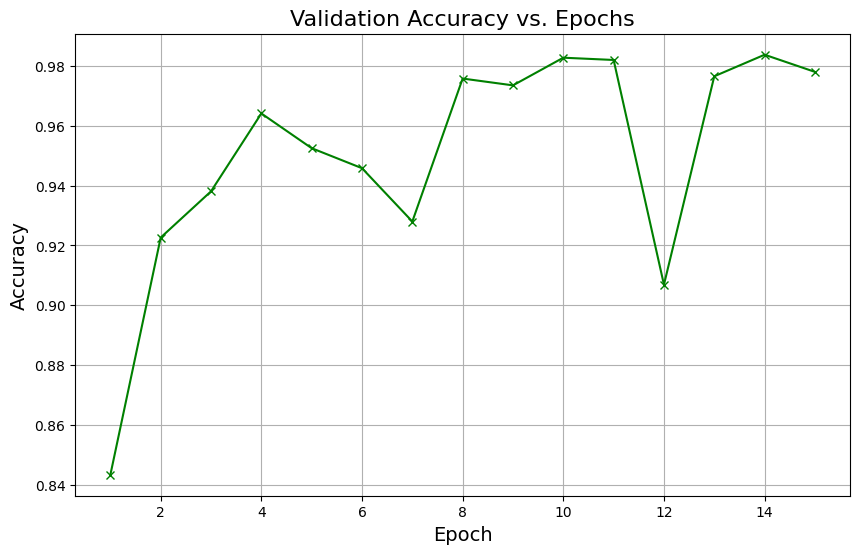

In [ ]:
plot_accuracies(history)

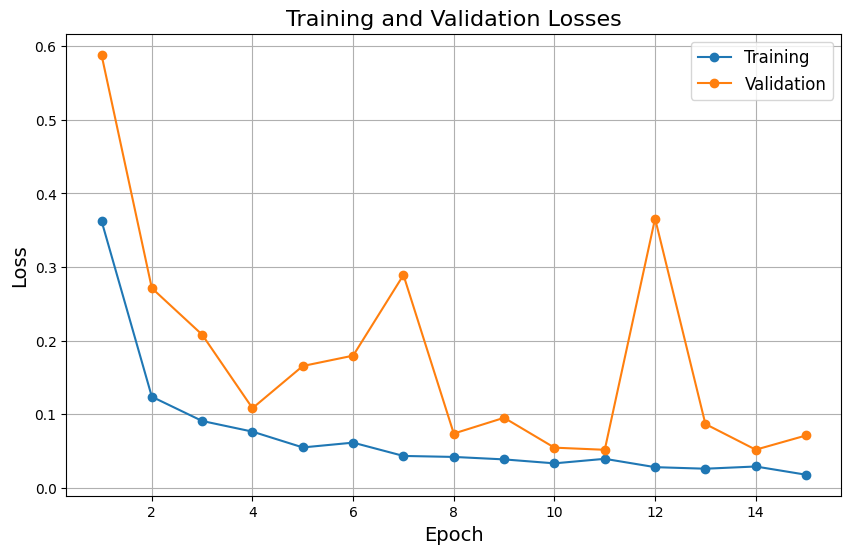

In [ ]:
plot_losses(history)


In [ ]:
evaluate(model,val_loader)

{'val_loss': 0.07100515067577362, 'val_acc': 0.9779356122016907}

### Find Precision, Recall, and F1-score and visualizing it through Heat Map

In [ ]:

import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_class_metrics(model, test_loader, num_classes):
    all_preds = []
    all_labels = []

    #iterate over the test loader to get predictions and true labels
    for images, labels in test_loader:
        preds = model(images)
        _, preds = torch.max(preds, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    #calculating precision, recall, and F1-score for each class
    precision = precision_score(all_labels, all_preds, average=None)
    recall = recall_score(all_labels, all_preds, average=None)
    f1 = f1_score(all_labels, all_preds, average=None)

    #dictionary to store class-wise metrics
    class_metrics = {}
    for i in range(num_classes):
        class_metrics[i] = {'precision': precision[i], 'recall': recall[i], 'f1-score': f1[i]}

    return class_metrics


num_classes = len(dataset.classes)
class_metrics = calculate_class_metrics(model, test_loader, num_classes)

# Print class-wise metrics
##for class_idx, metrics in class_metrics.items():
  ##  print(f"Class {class_idx}: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1-score={metrics['f1-score']:.4f}")

def pretty_print_class_metrics(class_metrics):
    metrics_df = pd.DataFrame.from_dict(class_metrics, orient='index')
    metrics_df.index.name = 'Class'
    print(metrics_df)


def visualize_class_metrics(class_metrics):
    #dataFrame from dictionary
    metrics_df = pd.DataFrame.from_dict(class_metrics, orient='index')

    #heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(metrics_df, annot=True, cmap="YlGnBu", fmt=".4f", linewidths=.5)
    plt.title('Class-wise Performance Metrics', fontsize=16)
    plt.xlabel('Metrics', fontsize=14)
    plt.ylabel('Class', fontsize=14)
    plt.show()




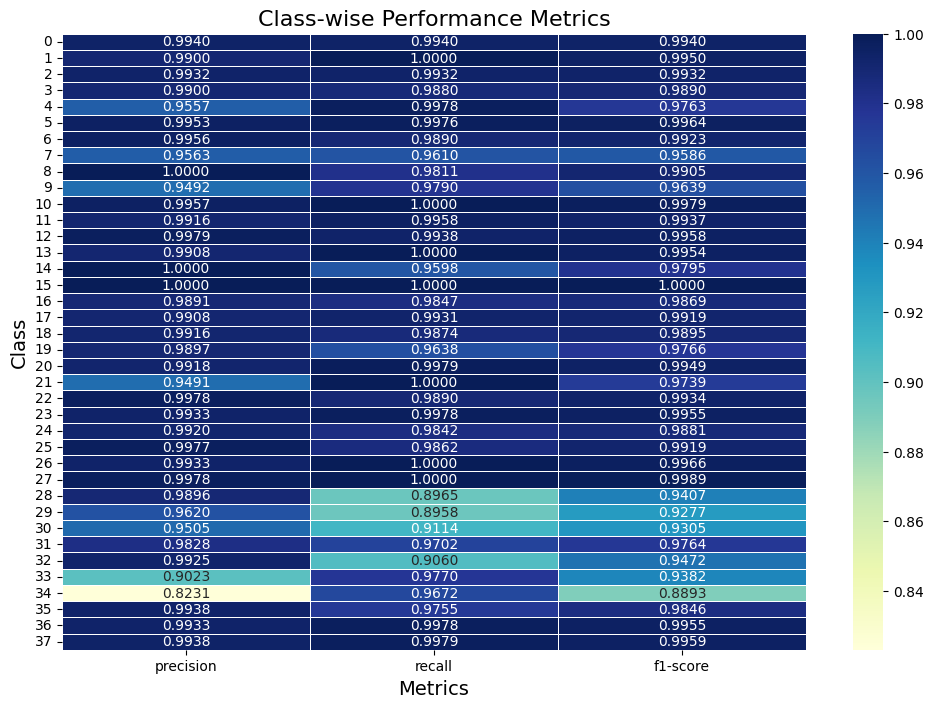

In [ ]:
#call to Performance Metrics
visualize_class_metrics(class_metrics)


###Finding AUC-ROC Scores for Each Class

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np

def compute_auc_roc(model, test_loader, num_classes):
    all_probs = []
    all_labels = []

    #for loop to get predicted probabilities and true labels
    for images, labels in test_loader:
        preds = model(images)
        probs = torch.softmax(preds.detach(), dim=1).cpu().numpy()  # Detach gradient before converting to NumPy
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())

    #convert predictions and labels to numpy arrays
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    #compute AUC-ROC score for each class
    auc_roc_scores = []
    for class_idx in range(num_classes):
        auc_roc = roc_auc_score((all_labels == class_idx).astype(int), all_probs[:, class_idx])
        auc_roc_scores.append(auc_roc)


    return auc_roc_scores

num_classes = len(dataset.classes)
auc_roc_scores = compute_auc_roc(model, test_loader, num_classes)

# Print AUC-ROC scores for each class
##for class_idx, score in enumerate(auc_roc_scores):
   ## print(f"Class {class_idx}: AUC-ROC Score={score:.4f}")




/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


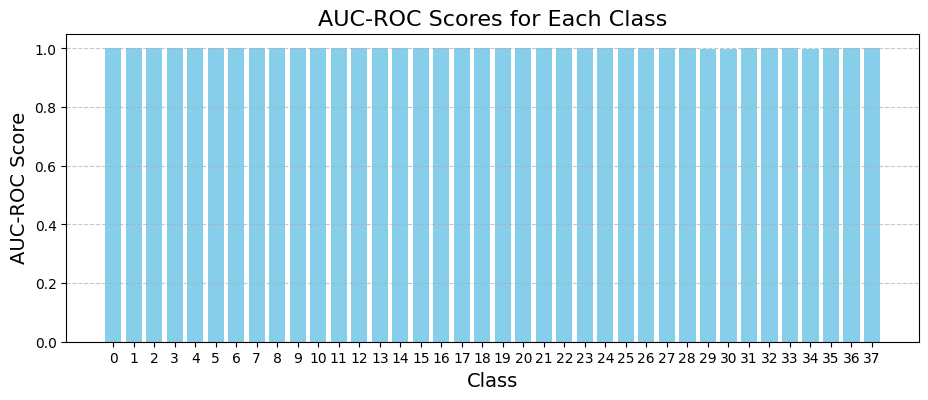

In [ ]:
def plot_auc_roc(auc_roc_scores):
    num_classes = len(auc_roc_scores)
    class_ids = range(num_classes)

    plt.figure(figsize=(11, 4))
    plt.bar(class_ids, auc_roc_scores, color='skyblue')
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('AUC-ROC Score', fontsize=14)
    plt.title('AUC-ROC Scores for Each Class', fontsize=16)
    plt.xticks(class_ids)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_auc_roc(auc_roc_scores)

###Plotig Confusion matrix


In [ ]:
from sklearn.metrics import confusion_matrix

def generate_confusion_matrix(model, test_loader, num_classes):
    all_preds = []
    all_labels = []

    #for loop to iterate over the test loader to get predictions and true labels
    for images, labels in test_loader:
        preds = model(images)
        _, preds = torch.max(preds, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    #confusion matrix
    confusion_mat = confusion_matrix(all_labels, all_preds)


    plt.figure(figsize=(12, 10))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


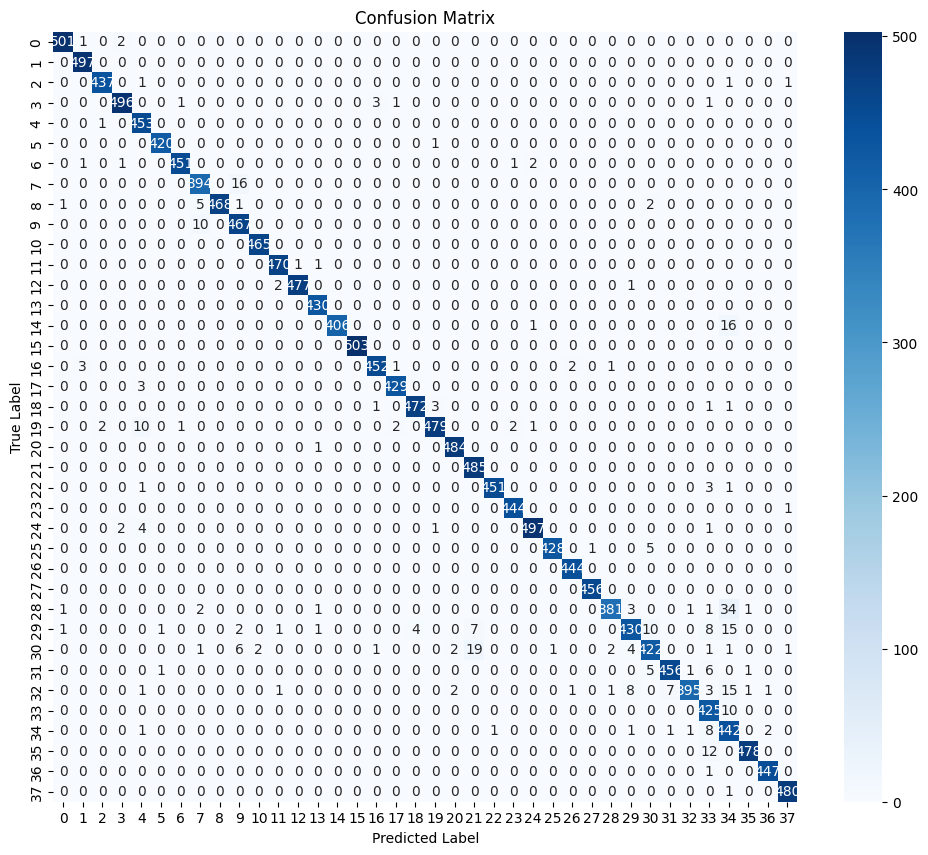

In [ ]:
#generate Confusion Matrix
num_classes = len(dataset.classes)
generate_confusion_matrix(model, test_loader, num_classes)

## Evaluation and Prediction on Test Data

In [ ]:
x = evaluate(model,test_loader)
x

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


{'val_loss': 0.06858877092599869, 'val_acc': 0.9795013070106506}

#### **Accuracy of the model on test data : 97.16%**

## Prediction on some single image of test data

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

Label: Cherry_(including_sour)___healthy , Predicted: Cherry_(including_sour)___healthy


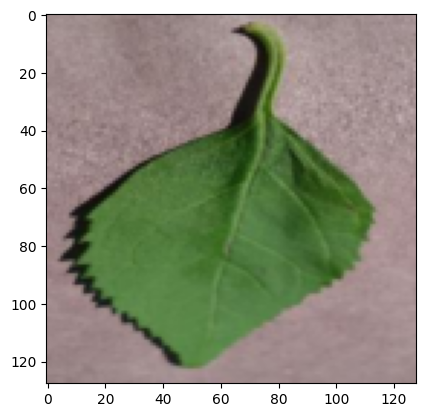

In [ ]:
img, label = test_ds[3210]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Apple___Black_rot , Predicted: Apple___Black_rot


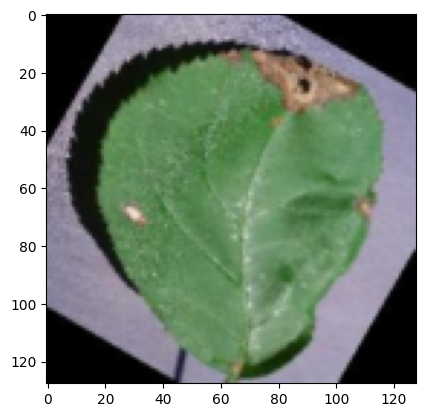

In [ ]:
img, label = test_ds[543]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Orange___Haunglongbing_(Citrus_greening) , Predicted: Orange___Haunglongbing_(Citrus_greening)


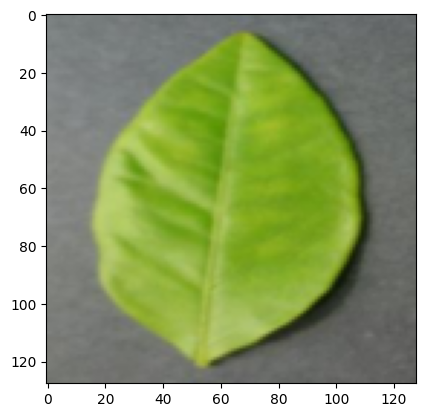

In [ ]:
img, label = test_ds[7123]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))